In [106]:
import numpy as np
from matplotlib import pyplot as plt, ticker as mticker
from tqdm.auto import tqdm, trange
import matplotlib as mpl
from scipy.integrate import quad
from scipy.sparse import csr_matrix
import numba

sys.path.append('../Numerical_methods')
from matrix_calculator import A_matrix
from bachelor_funcs import color_use
from ODE_schemes import stencil_calc

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 15}
mpl.rc('font', **font)

In [107]:
N = 300
r_i = 0.01
r_f = 100
r = np.logspace(np.log(r_i), np.log(r_f), N, base = np.exp(1))
r_log = np.log(r)
Δr_log = r_log[1] - r_log[0]

In [108]:
γ = 1
t_s = (3 * (2 - γ)**2)**(-1)
print(t_s)

t_func = lambda T, ts: (T - 1) * ts
T_func = lambda t, ts: t / ts + 1
T_plot = np.array([1, 2, 4, 8])
t_func(T_plot, t_s)

0.3333333333333333


array([0.        , 0.33333333, 1.        , 2.33333333])

In [109]:
# Inital surface density:
def Σ_initial(x, γ = 1):
    return (3 * np.pi * x**γ)**(-1) * np.exp(-x**(2 - γ))

C = 1 / quad(Σ_initial, r_i, r_f)[0]

def Σ_initial_norm(x, γ = 1):
    return C * Σ_initial(x, γ)

# Analytical soltuion:
def Σ(r, T, γ = 1):
    not_norm = lambda r : (3 * np.pi * r**γ)**(-1) * T**(-(5/2 - γ) / (2 - γ)) * np.exp(-r**(2 - γ) / T)
    #C = 1 / quad(not_norm, x_i, x_f)[0]
    return C * not_norm(r)

$$\frac{\partial}{\partial r_{log}} = \frac{1}{r}\frac{\partial}{\partial r_{log}}$$

In [135]:
D1_log = A_matrix(4, 1, N + 3)
D1_log[0, :4] = [-3/2, 2, -1/2, 0]
D1_log[-1, -4:] = [0, 1/2, -2, 3/2]
sD1_log = csr_matrix(D1_log.copy() / Δr_log)

In [136]:
r_i1 = np.exp(r_log[0] - 2 * Δr_log) 
r_i2 = np.exp(r_log[0] - 1 * Δr_log)
front = np.array([r_i1, r_i2])

r_f = np.exp(r_log[-1] + 1 * Δr_log)
back = np.array([r_f])

r_ghost = np.concatenate((front, r, back))

In [137]:
len(r_ghost[2:-1])

300

In [171]:
#### WORKS #### Runtime: 37.2s
def dΣdt(Σ, Δt):
    inner = Σ * r**(3/2)

    ghost_i1 = inner[0]**2 / (inner[1])
    ghost_i2 = inner[0]**2 / (inner[2])
    ghost_f = inner[-1]**2 / (inner[-2])

    inner_ghost = np.concatenate((np.array([ghost_i2, ghost_i1]), inner, np.array([ghost_f])))

    dr_inner = r_ghost**(-1/2) * (sD1_log @ inner_ghost)

    step = (3/r_ghost**2) *  (sD1_log @ dr_inner)
    
    return Σ + Δt * step[2 : -1]

In [167]:
### WORKS ### Runtime: 58.2s
def dΣdt2(Σ, Δt):
    inner = Σ * r**(3/2)

    ghost_i1 = inner[0]**2 / (inner[1])
    ghost_i2 = inner[0]**2 / (inner[2])

    inner_ghost = np.concatenate((np.array([ghost_i2, ghost_i1]), inner))

    dr_inner = r_ghost[:-1]**(-1/2) * (np.roll(inner_ghost, -1) - np.roll(inner_ghost, 1)) / (2 * Δr_log)

    step = (3/r_ghost[:-1]**2) *  (np.roll(dr_inner, -1) - np.roll(dr_inner, 1)) / (2 * Δr_log)

    
    return Σ + Δt * step[2 :]

In [172]:
Σ0 = Σ_initial_norm(r)
sol = []
Δt_solved = []
t_solved = []

Δt = 1e-6
rejected = 0
step = 0
t = 0
ε_rel=1e-2
ε_abs=1e1
error_area = 1e1

while t < t_func(T_plot[-1], t_s):
    res = dΣdt(Σ0, Δt)

    δΣ = abs((res - Σ0) / (np.abs(Σ0) + ε_abs)).max()
    ε_tol = ε_rel

    if np.any(res < 0):
        Δt = 0.1 * Δt
        continue

    Δt_next =  0.95*(ε_tol/δΣ) * Δt
    if Δt_next > 1.2 * Δt:
        Δt_next = 1.2 * Δt
    if Δt_next < 0.1 * Δt:
        Δt_next = 0.1 * Δt 

    
    if any(np.isnan(res)) == True:
        break

    if δΣ <= ε_tol and np.all(res > 0):
        step += 1
        t += Δt
        sol.append(res)
        Σ0 = res
        Δt_solved.append(Δt)
        t_solved.append(t)
    else:
        rejected += 1    
    Δt = Δt_next 

In [173]:
i_t = []
for T in T_plot:
    i_t.append(np.argmin(abs(T_func(np.asarray(t_solved), t_s) - T)))
i_t

[0, 46853, 140285, 326911]

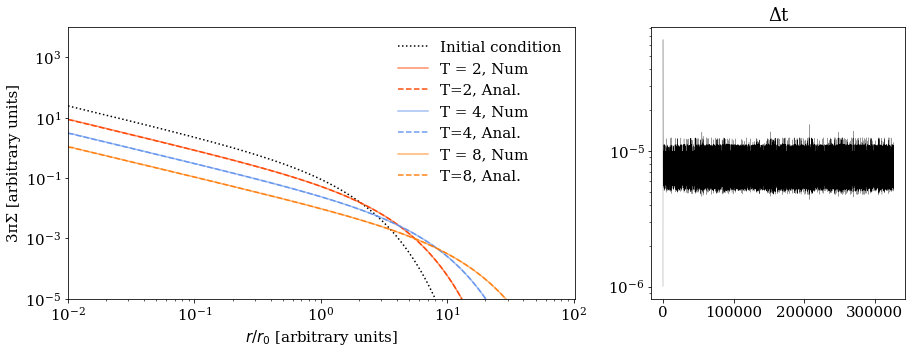

In [174]:
fig, axs = plt.subplots(1,2, figsize=(15,5), gridspec_kw={'width_ratios': [2, 1]})

axs[0].set(xlabel='$r/r_0$ [arbitrary units]', ylabel='3πΣ [arbitrary units]', ylim = (1e-5, 1e4), xlim = (r_i, r_f))
axs[0].loglog(r, Σ_initial_norm(r), ls=':', label = 'Initial condition', c = 'black')

for i, col in zip(i_t[1:], color_use):
    axs[0].loglog(r, sol[i], label = f'T = {T_func(t_solved[i],t_s):1.0f}, Num', c = col, alpha = 0.6)
    axs[0].loglog(r, Σ(r, T_func(np.asarray(t_solved)[i], t_s)), c = col, ls='--', alpha = 0.95, label = f'T={T_func(np.asarray(t_solved)[i], t_s):1.0f}, Anal.')
axs[0].legend(frameon = False)

axs[1].set(title = 'Δt')
axs[1].semilogy(Δt_solved, '-', lw=0.2, c = 'black')